# Preparation

## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Environment Setup

In [2]:
!pip install -i https://test.pypi.org/simple/ supervision==0.3.0
!pip install -q transformers
!pip install -q pytorch-lightning
!pip install -q timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.4 MB/s eta 0:00:00


In [10]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

import supervision
import transformers
import pytorch_lightning

print(
    "; supervision:", supervision.__version__,
    "; transformers:", transformers.__version__,
    "; pytorch_lightning:", pytorch_lightning.__version__
    )

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.1 ; cuda:  cu118
; supervision: 0.3.0 ; transformers: 4.35.2 ; pytorch_lightning: 2.1.2


## Load Model from HuggingFace Model Library

In [4]:
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor


# settings
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = 'facebook/detr-resnet-50'

image_processor = DetrImageProcessor.from_pretrained(CHECKPOINT)
model = DetrForObjectDetection.from_pretrained(CHECKPOINT)
model.to(DEVICE)

preprocessor_config.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

## Create COCO DataLoaders

### Define Dataset

In [6]:
import os
import torchvision


# settings
dataset_location = f"/content/drive/MyDrive/9조 프로젝트/Data/Dataset"
ANNOTATION_FILE_NAME = "labels.json"
TRAIN_DIRECTORY = os.path.join(dataset_location, "train")
VAL_DIRECTORY = os.path.join(dataset_location, "val")
TEST_DIRECTORY = os.path.join(dataset_location, "test")


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        dataset_directory_path: str,
        image_directory_path: str,
        image_processor,
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(
    dataset_directory_path=f"{TRAIN_DIRECTORY}",
    image_directory_path=f"{TRAIN_DIRECTORY}//data",
    image_processor=image_processor,
    train=True)
VAL_DATASET = CocoDetection(
    dataset_directory_path=f"{VAL_DIRECTORY}",
    image_directory_path=f"{VAL_DIRECTORY}//data",
    image_processor=image_processor,
    train=False)
TEST_DATASET = CocoDetection(
    dataset_directory_path=f"{TEST_DIRECTORY}",
    image_directory_path=f"{TEST_DIRECTORY}//data",
    image_processor=image_processor,
    train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=99.60s)
creating index...
index created!
loading annotations into memory...
Done (t=21.49s)
creating index...
index created!
loading annotations into memory...
Done (t=0.42s)
creating index...
index created!
Number of training examples: 25493
Number of validation examples: 2936
Number of test examples: 2913


### Visualize Data Entry

Image #14533


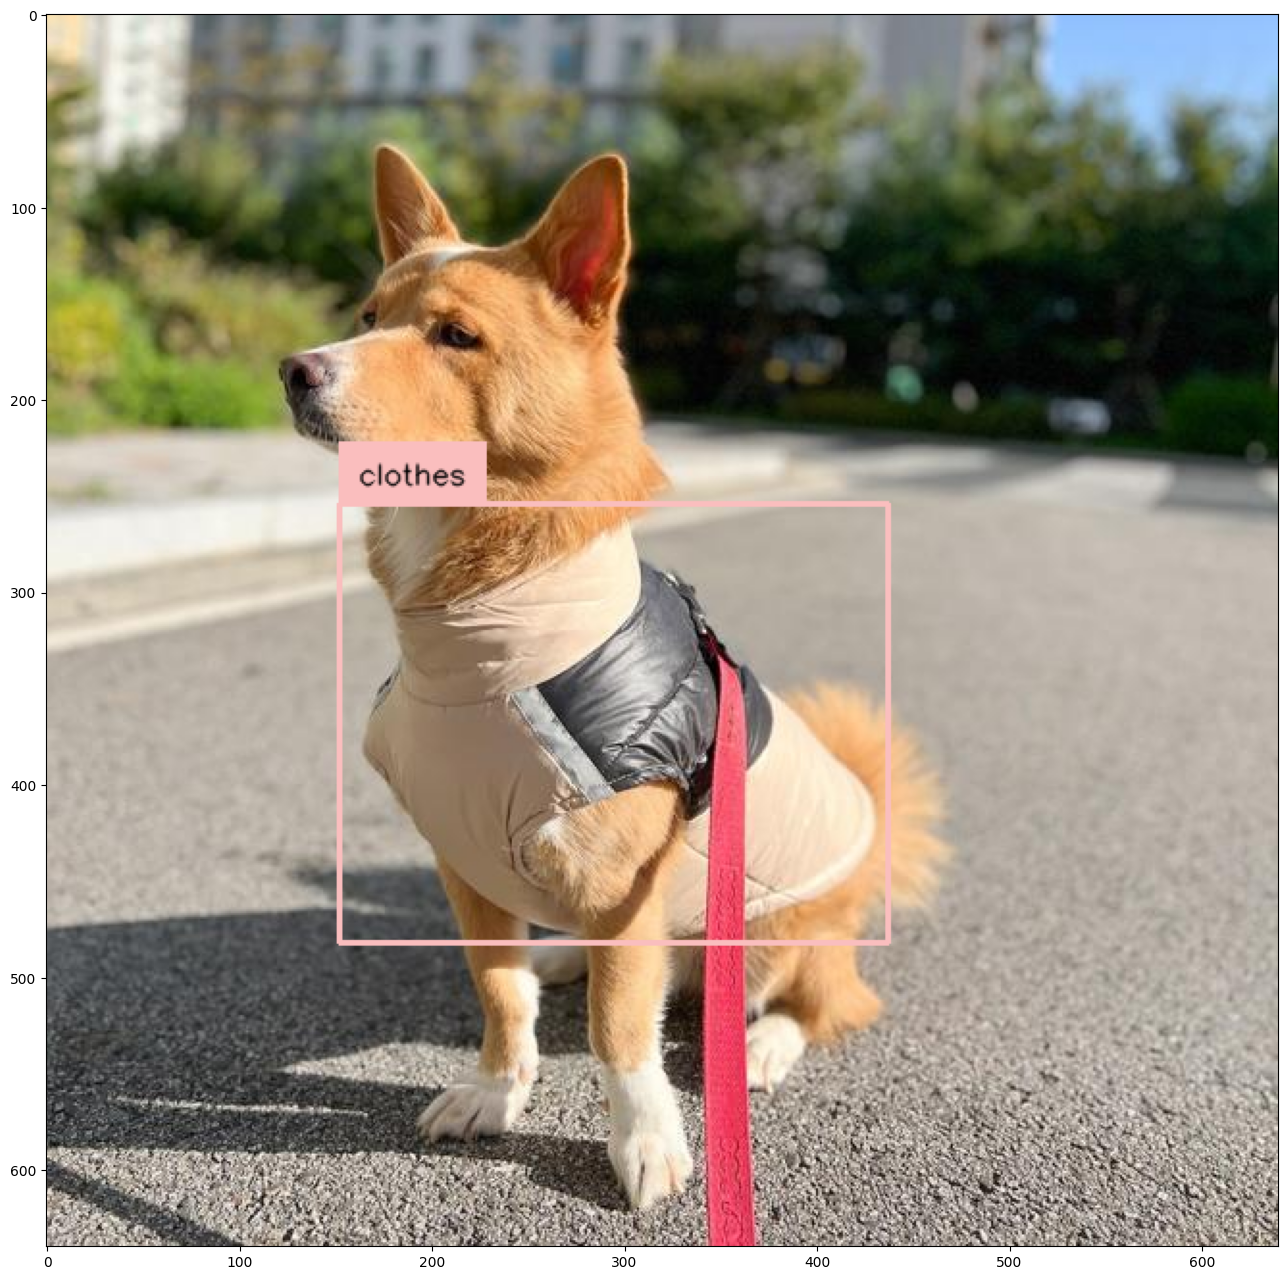

In [9]:
import random
import cv2
import numpy as np
import supervision as sv


# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

# we will use id2label function for training
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

labels = [
    f"{id2label[class_id]}"
    for _, _, class_id, _
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline
sv.show_frame_in_notebook(image, (16, 16))

### Define Dataloader

In [11]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    # DETR authors employ various image sizes during training, making it not possible
    # to directly batch together images. Hence they pad the images to the biggest
    # resolution in a given batch, and create a corresponding binary pixel_mask
    # which indicates which pixels are real/which are padding
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=8, num_workers=12, shuffle=True, pin_memory=True, persistent_workers=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=8, num_workers=12, pin_memory=True, persistent_workers=True)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=8, num_workers=24, pin_memory=True, persistent_workers=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Create Trainer with Pytorch Lightning

### Define Detr LightningModule

In [12]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection, DetrForObjectDetection
import torch


class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path=CHECKPOINT,
            revision = 'no_timm',
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )

        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss, on_step=True, on_epoch=True, logger=True)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation/loss", loss,on_step=True, on_epoch=True, logger=True)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def test_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step, and the average across the epoch
        self.log("test_loss", loss, on_step=True, on_epoch=True, logger=True)
        for k,v in loss_dict.items():
            self.log("test_" + k, v.item())

        return loss

    def configure_optimizers(self):
        # DETR authors decided to use different learning rate for backbone
        # you can learn more about it here:
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L22-L23
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L131-L139
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

    def test_dataloader(self):
        return TEST_DATALOADER

# Prediction

## Prepare finetuned DeTR Model

### Load Model from finetuned checkpoint

In [15]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

ckpt_path = f"/content/drive/MyDrive/9조 프로젝트/Data/Dataset/DETR_log/lightning_logs/version_6/checkpoints/epoch=29-step=95610.ckpt"
ckpt = torch.load(ckpt_path)

model.load_state_dict(ckpt['state_dict'])

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([11, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([11]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

### Set Model as eval mode

In [16]:
model.eval()

Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): ResNetBackbone(
            (embedder): ResNetEmbeddings(
              (embedder): ResNetConvLayer(
                (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
                (normalization): DetrFrozenBatchNorm2d()
                (activation): ReLU()
              )
              (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            )
            (encoder): ResNetEncoder(
              (stages): ModuleList(
                (0): ResNetStage(
                  (layers): Sequential(
                    (0): ResNetBottleNeckLayer(
                      (shortcut): ResNetShortCut(
                        (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                        (normalization): DetrFrozenBatchNorm2d

## Inference

### Load image and predict output

In [17]:
from PIL import Image
image = Image.open(f"/content/drive/MyDrive/Personal Colab/진현/test_image/test.jpg").convert("RGB")

inputs = image_processor(images=image, return_tensors="pt")


with torch.no_grad():
    outputs = model(**inputs)

### Rank queries from output

In [18]:
width, height = image.size
postprocessed_outputs = image_processor.post_process_object_detection(outputs,target_sizes=[(height, width)],threshold=0.15)
print(postprocessed_outputs)

[{'scores': tensor([0.1774, 0.3595, 0.9440, 0.2396]), 'labels': tensor([1, 1, 1, 1]), 'boxes': tensor([[1402.1736,  782.6295, 1918.6919, 1290.1857],
        [1382.3141,  500.4753, 1905.6582, 1291.7067],
        [1368.6541,  497.2560, 1926.8164, 1295.1057],
        [1665.5828,  589.3483, 1957.4165, 1292.8915]])}]


### Plot bounding boxes on image

In [21]:
from PIL import ImageDraw
from IPython.display import display

image = Image.open(f"/content/drive/MyDrive/Personal Colab/진현/test_image/test.jpg").convert("RGB")
draw = ImageDraw.Draw(image)

for score, label, box in zip(postprocessed_outputs[0]['scores'], postprocessed_outputs[0]['labels'], postprocessed_outputs[0]['boxes']):
    box = [coordinate.item() for coordinate in box]  # Convert from tensor to list of coordinates
    draw.rectangle(box, outline="red", width=5)
    # Optionally, add the label and score
    draw.text((box[0], box[1]), f"{label.item()} ({score.item():.2f})", fill="red")

display(image)

Output hidden; open in https://colab.research.google.com to view.

# Process Image

## Crop Images on bounding boxes

In [24]:
import torchvision.transforms as T


bounding_boxes = [d['boxes'] for d in postprocessed_outputs]
cropped_images = []
for bbox in bounding_boxes[0]:
    # Each bbox is in the format (x_min, y_min, x_max, y_max)
    left, top, right, bottom = bbox.int()

# Calculate the height and width from the bounding box
    height = bottom - top
    width = right - left

    # Crop and add to list
    cropped_image = T.functional.crop(image, top.item(), left.item(), height.item(), width.item())
    cropped_images.append(cropped_image)

## Resize cropped image

In [26]:
# Define the desired width and height for resizing
resized_width = 224
resized_height = 224

# Define transforms for resizing
resize = T.Resize(size=(resized_width, resized_height))

# Create a list for resized images
resized_images = list()

# Resize each image in cropped_images list
for cropped_image in cropped_images:
    resized_image = resize(cropped_image)
    resized_images.append(resized_image)


In [28]:
# resized_images 리스트 안에 cropped&resized 이미지 담겨있습니다. 이걸 for문으로 불러와서 유사도 모델에 넣어주면 될 것 같습니다!
resized_images

[<PIL.Image.Image image mode=RGB size=224x224>,
 <PIL.Image.Image image mode=RGB size=224x224>,
 <PIL.Image.Image image mode=RGB size=224x224>,
 <PIL.Image.Image image mode=RGB size=224x224>]